# flower dataset
![daisy](img/488202750_c420cbce61.jpg)

## folder structure
* root/
    * |___daisy/*.jpg
    * |___dandelion/*.jpg
    * |___roeses/*.jpg
    * |___sunflowers/*.jpg
    * |___tulips/*.jpg

## Grab image files

In [1]:
import os
import glob

# grab all image data
flower_dataset_root = 'D:\\db\\flower_photos'
daisy_fns = glob.glob(os.path.join(flower_dataset_root, 
                                   'daisy', '*.jpg'))
dandelion_fns = glob.glob(os.path.join(flower_dataset_root, 
                                       'dandelion', '*.jpg'))
roses_fns = glob.glob(os.path.join(flower_dataset_root, 
                                   'roses', '*.jpg'))
sunflowers_fns = glob.glob(os.path.join(flower_dataset_root, 
                                        'sunflowers', '*.jpg'))
tulips_fns = glob.glob(os.path.join(flower_dataset_root, 
                                    'tulips', '*.jpg'))

print('daisy_files: {:d}'.format(len(daisy_fns)))
print('dandelion_files: {:d}'.format(len(dandelion_fns)))
print('roses_files: {:d}'.format(len(roses_fns)))
print('sunflowers_files: {:d}'.format(len(sunflowers_fns)))
print('tulips_files: {:d}'.format(len(tulips_fns)))

daisy_files: 633
dandelion_files: 898
roses_files: 641
sunflowers_files: 699
tulips_files: 799


In [2]:
import numpy as np

# convert to numpy array
daisy_fns = np.asarray(daisy_fns)
dandelion_fns = np.asarray(dandelion_fns)
roses_fns = np.asarray(roses_fns)
sunflowers_fns = np.asarray(sunflowers_fns)
tulips_fns = np.asarray(tulips_fns)
print(daisy_fns.shape)
print(dandelion_fns.shape)

(633,)
(898,)


In [3]:
# create labels
daisy_labels = np.ones_like(daisy_fns, dtype=np.int32) * 0
dandelion_labels = np.ones_like(dandelion_fns, dtype=np.int32) * 1
roses_labels = np.ones_like(roses_fns, dtype=np.int32) * 2
sunflowers_labels = np.ones_like(sunflowers_fns, dtype=np.int32) * 3
tulips_labels = np.ones_like(tulips_fns, dtype=np.int32) * 4
print(daisy_labels.shape)
print(dandelion_labels.shape)

# create class_label_map
class_label_map = {
    0: 'daisy', 
    1: 'dandelion', 
    2: 'roses', 
    3: 'sunflowers', 
    4: 'tulips'
}
print(class_label_map)

(633,)
(898,)
{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}


In [4]:
# merge dataset
images = np.concatenate((daisy_fns, dandelion_fns, roses_fns, sunflowers_fns, tulips_fns), axis=0)
labels = np.concatenate((daisy_labels, dandelion_labels, roses_labels, sunflowers_labels, tulips_labels), axis=0)
print(images.shape)
print(labels.shape)

(3670,)
(3670,)


In [5]:
# split dataset into train & test sets
from sklearn.model_selection import train_test_split

test_size = 0.2
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=test_size, shuffle=True)
print(images_train.shape, labels_train.shape)
print(images_test.shape, labels_test.shape)

(2936,) (2936,)
(734,) (734,)


## Create input_fn(): tf.data.Dataset API

In [6]:
import tensorflow as tf

In [7]:
# load image & label
def parse_fn(image_fn, label, is_training, input_size):
    # decode image to uint8 (0 ~ 255)
    image = tf.read_file(image_fn)
    image = tf.image.decode_image(image, channels=3)

    # convert image to flot32 (0.0 ~ 1.0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # data augmentation on training
    if is_training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.resize_images(image, [input_size, input_size], 
                                       method=tf.image.ResizeMethod.BILINEAR)

    # set data type for label
    label = tf.cast(label, dtype=tf.int32)
    return image, label

In [8]:
# input_fn() to load flower dataset
def input_fn(image_fns, labels, epochs, batch_size, is_training, input_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_fns, labels))

    # shuffle & repeat for training dataset
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(image_fns))
        dataset = dataset.repeat(epochs)

    # decode & preprocess image and label
    dataset = dataset.map(
        map_func=lambda image_fn, label: parse_fn(image_fn, 
                                                  label, 
                                                  is_training, 
                                                  input_size),
        num_parallel_calls=8
    )

    # batch dataset with prefetch
    dataset = dataset.batch(batch_size).prefetch(batch_size)

    # create features & labels
    iterator = dataset.make_one_shot_iterator()
    images, labels = iterator.get_next()
    features = {'images': images}
    return features, labels

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

(1, 256, 256, 3)
(1,)
sunflowers


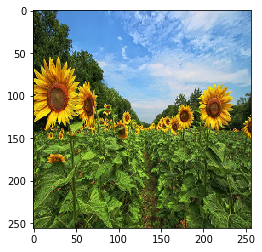

(1, 256, 256, 3)
(1,)
sunflowers


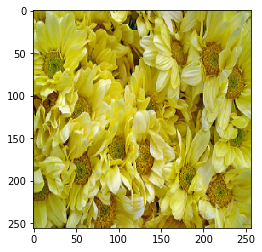

(1, 256, 256, 3)
(1,)
dandelion


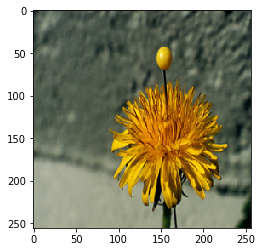

(1, 256, 256, 3)
(1,)
roses


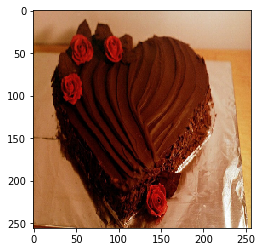

In [10]:
# test input_fn()
batch_size = 1
epochs = 1
input_size = 256
is_training = True
features, labels = input_fn(images_test, labels_test, epochs, batch_size, is_training, input_size)

display_max = 3
cnt = 0
with tf.Session() as sess:
    while True:
        try:
            feature, label = sess.run([features, labels])
            input_images = feature['images']    # input_images: [1, 256, 256, 3]
            input_labels = label                # input_labels: [1, ]

            print(input_images.shape)
            print(input_labels.shape)
            
            sample_image = input_images[0, :, :, :]
            sample_label = input_labels[0]
            print(class_label_map[sample_label])
            plt.imshow(sample_image)
            plt.show()
            
            cnt += 1
            if cnt > display_max:
                break
        except tf.errors.OutOfRangeError:
            print('End of dataset')
            break